In [1]:
%matplotlib inline

import os
from math import log2
import glob

import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display

from atntools.features import *
from atntools.plot_atn_csv import *

/Users/ben/miniconda3/envs/atn-tools/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Score functions
===============

Original environment score function
-----------------------------------

The environment score depends on:
- the number of species
- the following species-specific attributes:
    - total biomass
    - individual biomass
    - number of individuals (total biomass / individual biomass)
    - trophic level
    
(see create_feature_file.environmentScore())



Original environment score, without rounding
---

$$Score_t = \left( 5 log_2 \left( \sum_{i=1}^N b_i \left(\frac{B_{it}}{b_i}\right)^{T_i} \right) \right)^2 + N^2$$

In [2]:
def environmentScoreNoRounding(speciesData, nodeConfig, biomassData):

    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    scores = np.empty(numTimesteps)

    for timestep in range(numTimesteps):

        # Calculate the Ecosystem Score for this timestep
        biomass = 0
        numSpecies = 0
        for node in nodeConfig:
            nodeId = node['nodeId']
            perUnitBiomass = node['perUnitBiomass']

            # Sometimes biomass can go slightly negative.
            # Clip to 0 to avoid complex numbers in score calculation.
            totalBiomass = max(0, biomassData[nodeId][timestep])
            
            if totalBiomass > 0:
                numSpecies += 1

            biomass += perUnitBiomass * pow(totalBiomass / perUnitBiomass,
                    speciesData[nodeId]['trophicLevel'])
        if biomass > 0:
            biomass = log2(biomass) * 5
        scores[timestep] = pow(biomass, 2) + pow(numSpecies, 2)

    return scores

Using cube root instead of log
---

In [3]:
def environmentScoreCubeRoot(speciesData, nodeConfig, biomassData):
    """
    Compute the Ecosystem Score for all timesteps for the given data and return
    the score time series.  The calculations are taken from
    model.Ecosystem.updateEcosystemScore() in WoB_Server.
    """

    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    scores = np.empty(numTimesteps)

    for timestep in range(numTimesteps):

        # Calculate the Ecosystem Score for this timestep
        biomass = 0
        numSpecies = 0
        for node in nodeConfig:
            nodeId = node['nodeId']
            perUnitBiomass = node['perUnitBiomass']

            # Sometimes biomass can go slightly negative.
            # Clip to 0 to avoid complex numbers in score calculation.
            totalBiomass = max(0, biomassData[nodeId][timestep])
            
            if totalBiomass > 0:
                numSpecies += 1

            biomass += perUnitBiomass * pow(totalBiomass / perUnitBiomass,
                    speciesData[nodeId]['trophicLevel'])
        if biomass > 0:
            biomass = pow(biomass, 1/3) * 5
        scores[timestep] = pow(biomass, 2) + pow(numSpecies, 2)

    return scores

Shannon index, based on number of individuals
---

In [4]:
def shannonIndex(speciesData, nodeConfig, biomassData):
    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    scores = np.zeros(numTimesteps)
    
    for timestep in range(numTimesteps):
        individualCount = np.empty(len(nodeConfig))
        for i, node in enumerate(nodeConfig):
            speciesBiomass = max(0, biomassData[node['nodeId']][timestep])
            individualBiomass = node['perUnitBiomass']
            individualCount[i] = speciesBiomass / individualBiomass
        totalIndividuals = individualCount.sum()
        for i, node in enumerate(nodeConfig):
            if individualCount[i] == 0:
                continue
            proportion = individualCount[i] / totalIndividuals
            scores[timestep] -= proportion * log2(proportion)
    
    return scores

Shannon index, based on biomass
---

In [5]:
def shannonIndexBiomass(speciesData, nodeConfig, biomassData):
    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    scores = np.zeros(numTimesteps)
    
    for timestep in range(numTimesteps):
        speciesBiomass = np.empty(len(nodeConfig))
        for i, node in enumerate(nodeConfig):
            speciesBiomass[i] = max(0, biomassData[node['nodeId']][timestep])
        totalBiomass = speciesBiomass.sum()
        for i, node in enumerate(nodeConfig):
            if speciesBiomass[i] <= 0:
                continue
            proportion = speciesBiomass[i] / totalBiomass
            scores[timestep] -= proportion * log2(proportion)
    
    return scores

Biomass-based Shannon index times total biomass
---

Moved shannonIndexBiomassProduct into create_feature_file.py

Average of Shannon index by trophic level
---

In [6]:
def avgShannonIndexByTrophicLevel(speciesData, nodeConfig, biomassData):
    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    scores = np.zeros(numTimesteps)
    
    for timestep in range(numTimesteps):
        
        # Organize species biomass values into lists by trophic level
        sb = {}  # species biomass by trophic level
        for i, node in enumerate(nodeConfig):
            trophicLevel = round(speciesData[node['nodeId']]['trophicLevel'])
            biomass = max(0, biomassData[node['nodeId']][timestep])
            if trophicLevel not in sb:
                sb[trophicLevel] = [biomass]
            else:
                sb[trophicLevel].append(biomass)
        
        # Calculate Shannon index for each trophic level
        shannon = np.zeros(len(sb))  # note: index is not trophic level, which is not relevent at this point
        for i, biomassList in enumerate(sb.values()):
            totalBiomass = sum(biomassList)
            for biomass in biomassList:
                if biomass <= 0:
                    continue
                proportion = biomass / totalBiomass
                shannon[i] -= proportion * log2(proportion)
        
        scores[timestep] = shannon.mean()
        
        if timestep % 100 == 0:
            print("timestep {}".format(timestep))
            print("sb = {}".format(sb))
            print("shannon = {}".format(shannon))
    
    return scores

Net production
---

moved to create_feature_file.netProduction

Select score function and plot
---

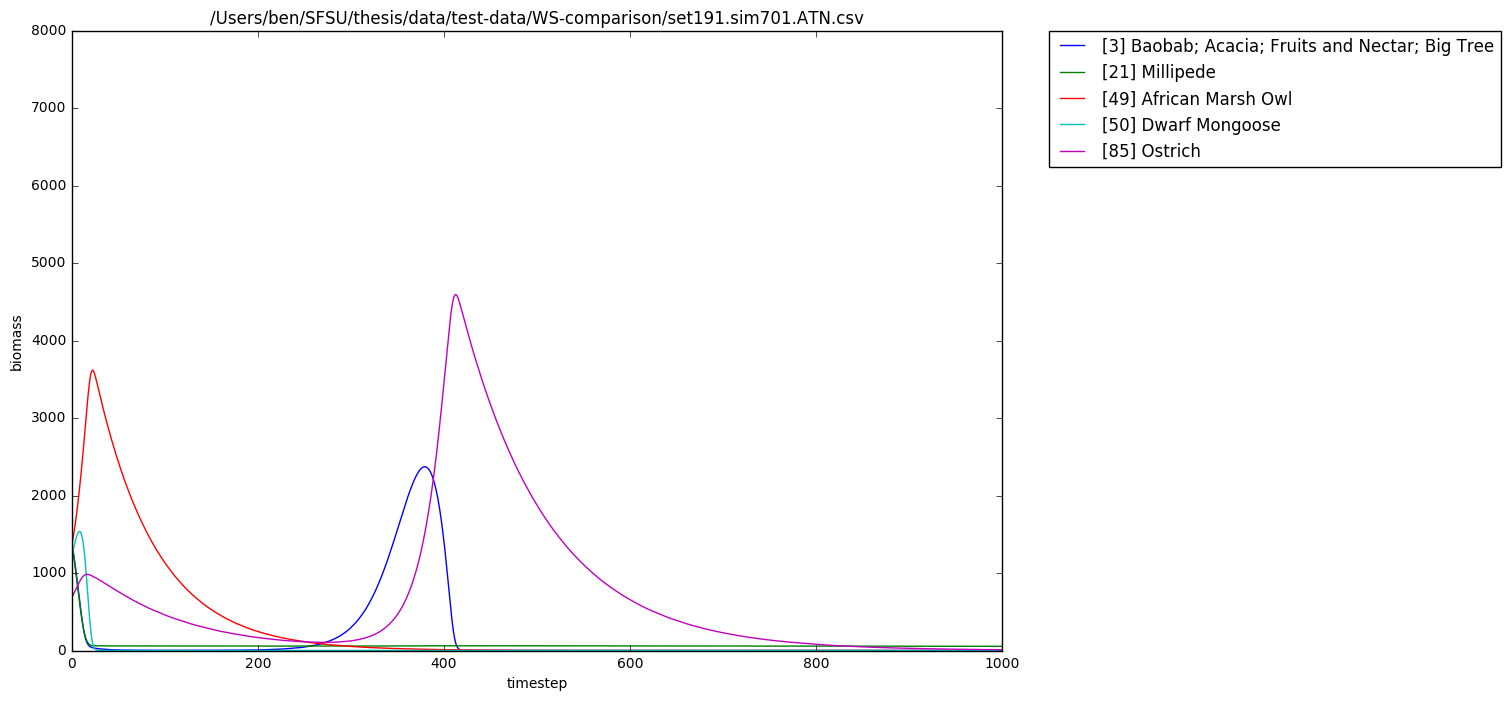

In [7]:
#score_function = environment_score
score_function = None

#csvDir = '../data/box/10-species/31-44-45-47-49-50-66-75-1001-1005/set93/biomass-data'
#csvDir = '../../data/set252/biomass-data'
#csvDir = '/Users/ben/SFSU/thesis/WoB_Server_ATNEngine/src/log/atn'
csvDir = '/Users/ben/SFSU/thesis/data/test-data/WS-comparison'
filenames = glob.glob(os.path.join(csvDir, '*.csv*'))

filenames.sort(key=lambda f: get_sim_number(f))
file_basenames = list(map(os.path.basename, filenames))

def plotFile(file_basename):
    filename = os.path.join(csvDir, file_basename)
    plot_csv(filename, score_function, show_legend=True, figsize=(12,8), xlim=(0, 1000), ylim=(0, 8000))
    #plot_csv(filename, score_function, show_legend=True, figsize=(8,4))
    plt.show()
    #plot_csv(os.path.join(csvDir, filename), score_function, show_legend=True)

selectWidget = interactive(plotFile, file_basename=widgets.Select(description="File", options=file_basenames))
display(selectWidget)

Shannon index test
---
Checking against first timestep of avgShannonIndexByTrophicLevel, set 1, sim 1, trophic level 2

In [8]:
blist = [1751.0, 1415.0]
total = sum(blist)
s = 0
for b in blist:
    proportion = b / total
    s -= proportion * log2(proportion)
print(s)

0.9918600928851626


Net production trend
---
It seems strange that the net production trend tends to be slightly positive.
The plot below demonstrates how the derivative of an exponentially decaying function has an upward trend.

For net production, a simple average is more appropriate than a trend. It is negative, as expected.

slope = 2.3928571428571432
average = -4.428571428571429


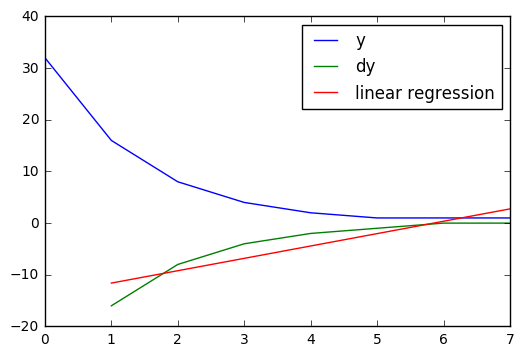

In [9]:
y = np.array([32, 16, 8, 4, 2, 1, 1, 1])
x = np.arange(len(y))
dy = (y - np.roll(y, 1))[1:]
plt.plot(x, y, label='y')
plt.plot(x[1:], dy, label='dy')

slope, intercept, r_value, p_value, std_err = stats.linregress(x[1:], dy)
plt.plot(x[1:], x[1:] * slope + intercept, label='linear regression')

plt.legend()

print("slope = {}".format(slope))
print("average = {}".format(np.mean(dy)))

Splitting biomass between multiple species in the top trophic level lowers score
---

In [10]:
print(20**3)
print(10**3 + 10**3)

8000
2000
